In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [120]:
class UpsampleBlock(nn.Module):
    def __init__(self,channels):
        super(UpsampleBlock,self).__init__()
        self.ct1 = nn.ConvTranspose2d(channels*2, channels,(2,2),2)
        
        self.conv1 = nn.Conv2d(channels*2, channels,(3,3))
        self.conv2 = nn.Conv2d(channels, channels,(3,3))
    
    def forward(self,input,skip_connection):
        tr = self.ct1(input)
        _, _, h, w = tr.shape
        skip_connection_cropped = skip_connection[:, :, :h, :w]
        
        concat = torch.concat([skip_connection_cropped,tr],dim=1)
        conv1 = self.conv1(concat)
        conv2 = self.conv2(conv1)

        return conv2

In [121]:
class UNet(nn.Module):
    def __init__(self,upblock,n_classes):
        super(UNet,self).__init__()
        
        self.convblock_1 = self.down_blockbuilder(3,first=True)
        self.convblock_2 = self.down_blockbuilder(64)
        self.convblock_3 = self.down_blockbuilder(128)
        self.convblock_4 = self.down_blockbuilder(256)
        self.convblock_5 = self.down_blockbuilder(512)
        self.mblock_1 = self.max_blockbuilder(64)
        self.mblock_2 = self.max_blockbuilder(128)
        self.mblock_3 = self.max_blockbuilder(256)
        self.mblock_4 = self.max_blockbuilder(512)
        
        self.up1 = upblock(512)
        self.up2 = upblock(256)
        self.up3 = upblock(128)
        self.up4 = upblock(64)
        self.convLast = nn.Conv2d(64,n_classes,(1,1))
        
    def down_blockbuilder(self,channels,out_channels=64,first=False):
        return nn.Sequential(
            nn.Conv2d(channels,(out_channels if first else channels*2),(3,3)),
            nn.ReLU(),
            nn.Conv2d((out_channels if first else channels*2),(out_channels if first else channels*2),(3,3)),
            nn.ReLU())
    def max_blockbuilder(self,channels):
        return nn.Sequential(
            nn.MaxPool2d((2,2)),)
    

    def forward(self,input):
        
        b1 = self.convblock_1(input)
        
        m1 = self.mblock_1(b1)
        b2 = self.convblock_2(m1)
        m2 = self.mblock_2(b2)
        
        b3 = self.convblock_3(m2)
        m3 = self.mblock_3(b3)
        
        b4 = self.convblock_4(m3)
        m4 = self.mblock_4(b4)
        
        b5 = self.convblock_5(m4)
        
        u1 = self.up1(b5,b4)
        u2 = self.up2(u1,b3)
        u3 = self.up3(u2,b2)
        u4 = self.up4(u3,b1)
        output = self.convLast(u4)
        return output

We'll load the Pascal VOC

In [6]:
import torchvision
import torchvision.transforms as transforms

In [7]:
image_transforms = transforms.Compose([
    transforms.Resize((572, 572)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])
mask_transforms = transforms.Compose([
    transforms.Resize((572, 572)),  
    transforms.PILToTensor(),  
])
batch_size = 1
momentum = 0.99

In [8]:
trainset = torchvision.datasets.VOCSegmentation(root='./data', year="2012", image_set="train", download=True,
                                 transform=image_transforms, target_transform=mask_transforms)
testset = torchvision.datasets.VOCSegmentation(root='./data', year="2012", image_set="val",
                               transform=image_transforms, target_transform=mask_transforms)

100%|██████████| 2.00G/2.00G [21:22<00:00, 1.56MB/s] 


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [9]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)

In [13]:
classes = (
    "background",  
    "aeroplane",   
    "bicycle",     
    "bird",        
    "boat",        
    "bottle",      
    "bus",         
    "car",         
    "cat",         
    "chair",       
    "cow",         
    "diningtable", 
    "dog",         
    "horse",       
    "motorbike",   
    "person",      
    "pottedplant", 
    "sheep",       
    "sofa",        
    "train",       
    "tvmonitor"    
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


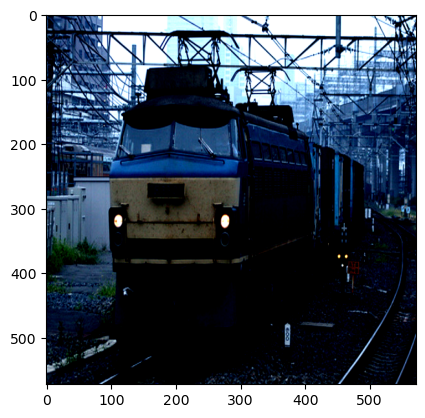

TypeError: only integer tensors of a single element can be converted to an index

In [14]:
import matplotlib.pyplot as plt
import numpy as np




def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [90]:
labels.shape

torch.Size([1, 1, 572, 572])

In [16]:
images.shape

torch.Size([1, 3, 572, 572])

In [122]:
unet = UNet(upblock=UpsampleBlock,n_classes=len(classes))

In [123]:
import torch.optim as optim
loss_func = nn.CrossEntropyLoss(ignore_index=255)
# optimizer = optim.SGD(unet.parameters(),lr=0.001,momentum=momentum)

In [127]:

optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.9)  


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


for epoch in range(2):  
    running_loss = 0
    for i, data in enumerate(trainloader):
        input, label = data
        optimizer.zero_grad()
        
        outputs = unet(input)
        _, _, h, w = outputs.shape
        label_cropped = label[:, :, :h, :w]
        label_cropped = label_cropped.squeeze(1).long()
        
        loss = loss_func(outputs, label_cropped)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0:  
            print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}')
    
    
    scheduler.step(running_loss)
    
    
    print(f'Epoch {epoch} completed, Average Loss: {running_loss/len(trainloader):.4f}')

Epoch 0, Batch 0, Loss: 2.8990
Epoch 0, Batch 10, Loss: 2.0725


KeyboardInterrupt: 

In [50]:
512*2

1024

In [101]:
data = iter(testloader)
img = next(data)

In [103]:
img.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
imshow(torchvision.utils.make_grid(images))

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 140, 140])
torch.Size([1, 256, 68, 68])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 28, 28]) torch.Size([1, 512, 64, 64])
torch.Size([1, 512, 64, 64]) torch.Size([1, 512, 56, 56]) torch.Size([1, 512, 56, 56])
torch.Size([1, 256, 136, 136]) torch.Size([1, 256, 104, 104]) torch.Size([1, 256, 104, 104])
torch.Size([1, 128, 280, 280]) torch.Size([1, 128, 200, 200]) torch.Size([1, 128, 200, 200])
torch.Size([1, 64, 568, 568]) torch.Size([1, 64, 392, 392]) torch.Size([1, 64, 392, 392])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


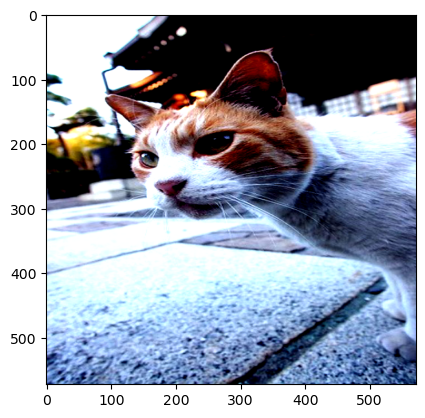

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..128.0].


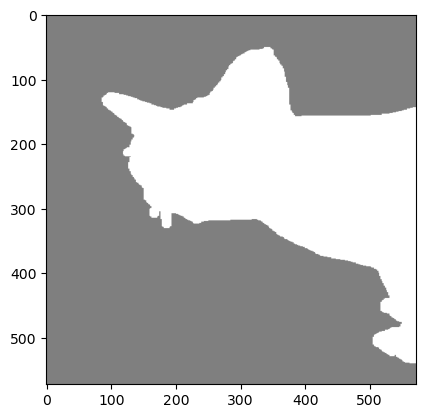

TypeError: Invalid shape (388, 388, 21) for image data

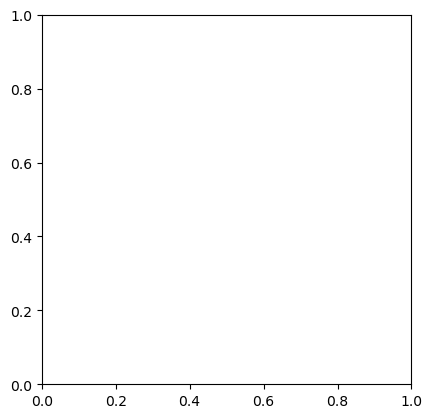

In [106]:
with torch.no_grad():
    test = iter(testloader)
    data = next(test)
    images,labels = data
    outputs = unet(images)
    imshow(torchvision.utils.make_grid(images))
    imshow(torchvision.utils.make_grid(labels))
    imshow(torchvision.utils.make_grid(outputs))


In [112]:
outputs.shape

torch.Size([1, 21, 388, 388])

In [115]:
predicted_classes = torch.argmax(outputs, dim=1)  


predicted_classes = predicted_classes.squeeze(0).cpu().numpy()

/var/folders/bx/gjl5c30x3bq2fbk_dmqhmms80000gn/T/ipykernel_5948/2829257927.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("tab20", 21)  # Predefined colormap for 21 classes


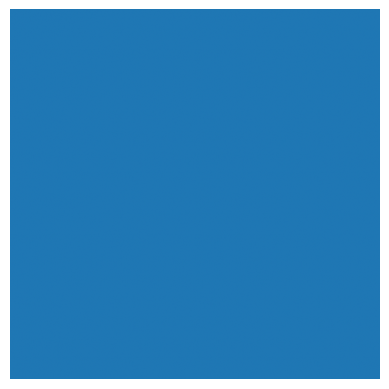

In [117]:
colormap = plt.cm.get_cmap("tab20", 21)  
colored_map = colormap(predicted_classes)  


plt.imshow(colored_map)
plt.axis("off")
plt.show()

In [118]:
unique_classes, counts = np.unique(predicted_classes, return_counts=True)
print("Unique classes and their counts:", dict(zip(unique_classes, counts)))

Unique classes and their counts: {np.int64(0): np.int64(150544)}


In [125]:
loss

tensor(1.9004, grad_fn=<NllLoss2DBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018410504..1.0473601].


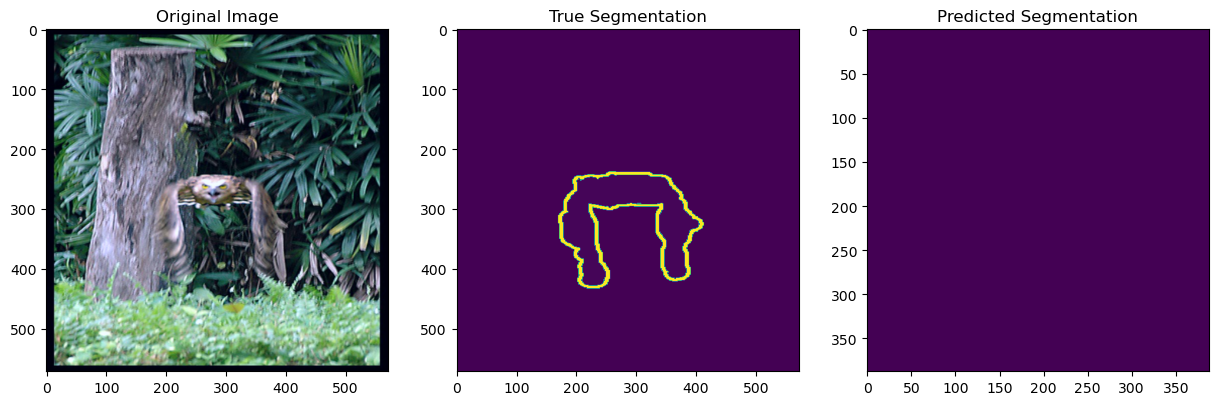

In [126]:
def visualize_prediction(model, image, label):
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        
        img = image.squeeze(0).permute(1,2,0).cpu().numpy()
        img = (img * 0.224) + 0.456  
        ax1.imshow(img)
        ax1.set_title('Original Image')
        
        
        ax2.imshow(label.squeeze(0).squeeze(0).cpu().numpy())
        ax2.set_title('True Segmentation')
        
        
        ax3.imshow(pred)
        ax3.set_title('Predicted Segmentation')
        
        plt.show()


test_image, test_label = next(iter(testloader))
visualize_prediction(unet, test_image, test_label)